# Test to see if VAE can produce a good model

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from util import random_observation_sequence, transform_observations

In [3]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

o, a, r = random_observation_sequence(env, 4096)
# o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
o_scaled = transform_observations(o, observation_max, observation_min, [0, 0])
o_scaled

array([[0.38368881, 0.5       ],
       [0.38341977, 0.49654052],
       [0.3830673 , 0.49546828],
       ...,
       [0.43643947, 0.40297936],
       [0.42763166, 0.38675667],
       [0.41788729, 0.37471523]])

In [6]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])

vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=1, kl_scaling=1)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [7]:
vae.fit(o_scaled, epochs=20, batch_size=64)

Epoch 1/20
 1/16 [>.............................] - ETA: 6s - loss: 7.5832 - reconstruction_loss: 0.7006 - kl_loss: 6.8826

2022-08-05 17:39:34.257835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 13ms/step - loss: 7.1811 - reconstruction_loss: 0.6944 - kl_loss: 6.1504
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 5.7105 - reconstruction_loss: 0.6889 - kl_loss: 4.7643
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 4.5758 - reconstruction_loss: 0.6863 - kl_loss: 3.6932
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 3.6884 - reconstruction_loss: 0.6835 - kl_loss: 2.8526
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 2.9963 - reconstruction_loss: 0.6817 - kl_loss: 2.1841
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 2.4364 - reconstruction_loss: 0.6806 - kl_loss: 1.6523
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 2.0079 - reconstruction_loss: 0.6797 - kl_loss: 1.2344
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 1.6456 - reconstruction_loss: 0.6790 - kl_loss:

In [8]:
o_scaled

array([[0.38368881, 0.5       ],
       [0.38341977, 0.49654052],
       [0.3830673 , 0.49546828],
       ...,
       [0.43643947, 0.40297936],
       [0.42763166, 0.38675667],
       [0.41788729, 0.37471523]])

In [9]:
vae(o_scaled)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0.36937124, 0.50063986],
       [0.37738952, 0.5028568 ],
       [0.3769708 , 0.49754095],
       ...,
       [0.37855145, 0.49886635],
       [0.37820333, 0.50229603],
       [0.3787679 , 0.49969763]], dtype=float32)>

In [29]:
a = np.random.random((100, 2))
vae.decoder(a)

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.37518728, 0.4894246 ],
       [0.3734936 , 0.48822287],
       [0.36795327, 0.48412043],
       [0.3670117 , 0.484143  ],
       [0.38132215, 0.49441734],
       [0.3803811 , 0.49602962],
       [0.37199798, 0.48713404],
       [0.36572155, 0.4837453 ],
       [0.36640424, 0.4833987 ],
       [0.36714956, 0.48486206],
       [0.37582153, 0.48941264],
       [0.37596548, 0.49572447],
       [0.35149646, 0.47657195],
       [0.3846336 , 0.4961655 ],
       [0.3614956 , 0.48020732],
       [0.37209067, 0.48700848],
       [0.35718486, 0.48053756],
       [0.36536002, 0.48376405],
       [0.37735426, 0.49476093],
       [0.36873078, 0.48457542],
       [0.38088804, 0.4932334 ],
       [0.38093433, 0.49468377],
       [0.36484897, 0.48438194],
       [0.34998766, 0.4749647 ],
       [0.37071866, 0.4892286 ],
       [0.37639737, 0.4929357 ],
       [0.35325596, 0.4771693 ],
       [0.36219457, 0.48085365],
       [0.3756031 , 0.4931

## MNIST

In [10]:
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train/255
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]**2)

In [11]:
x_train.max()

1.0

In [14]:
enc = create_encoder(10, 784, [256, 128])
dec = create_decoder(10, 784, [256, 128])

vae = VAE(enc, dec, [0]*10, [1]*10, llik_scaling=100, kl_scaling=1)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [15]:
vae.fit(x_train_flat, batch_size=64, epochs=20)

Epoch 1/20


2022-08-05 17:42:56.687580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 10s 10ms/step - loss: 31.9837 - reconstruction_loss: 26.0411 - kl_loss: 1.0561
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 24.9714 - reconstruction_loss: 23.2876 - kl_loss: 1.4308
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 23.9756 - reconstruction_loss: 21.2906 - kl_loss: 2.4547
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 23.2562 - reconstruction_loss: 20.1164 - kl_loss: 3.0498
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 22.9598 - reconstruction_loss: 19.5454 - kl_loss: 3.3720
Epoch 6/20
938/938 [==============================] - 9s 9ms/step - loss: 22.7624 - reconstruction_loss: 19.0245 - kl_loss: 3.6659
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 22.5649 - reconstruction_loss: 18.6936 - kl_loss: 3.8337
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 22.4186 - reconstr

In [16]:
out = vae(x_train_flat)
out = out.numpy().reshape(out.shape[0], 28, 28)
out.shape

(60000, 28, 28)

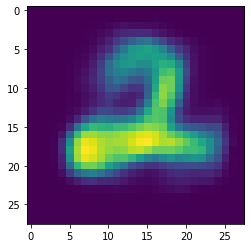

In [17]:
example = 16
plt.imshow(out[example])

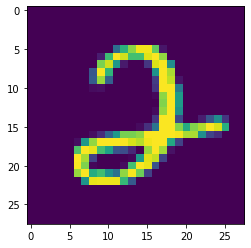

In [18]:
plt.imshow(x_train[example])

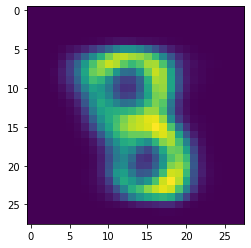

In [198]:
z = np.random.normal([0]*10, scale=[1]*10, size=(1, 10))
fake_num = vae.decoder(z).numpy().reshape(28,28)
plt.imshow(fake_num)